## Class 3: Beyond OLS

### Data Analysis and Regression
Tobias Rodriguez del Pozo, 2025

#### Outline for Today

1. Review of vanilla OLS and diagnostics
2. Ridge, LASSO, and Elastic Net
3. Robust Regression
4. Time series and GARCH/ARCH models

### Ridge and LASSO

Going back to review 1, remember that we had this issue:
$$
(X^TX)^{-1}
$$
Which, if $X^TX$ is not invertible, we have a problem. 

In fact, even if it is invertible, but "barely", we can have issues with numerical stability. Additionally, if we have a lot of features, we might still have a stable and invertible $X^TX$, but we might be overfitting the data and have redundant features which will show up out of sample.

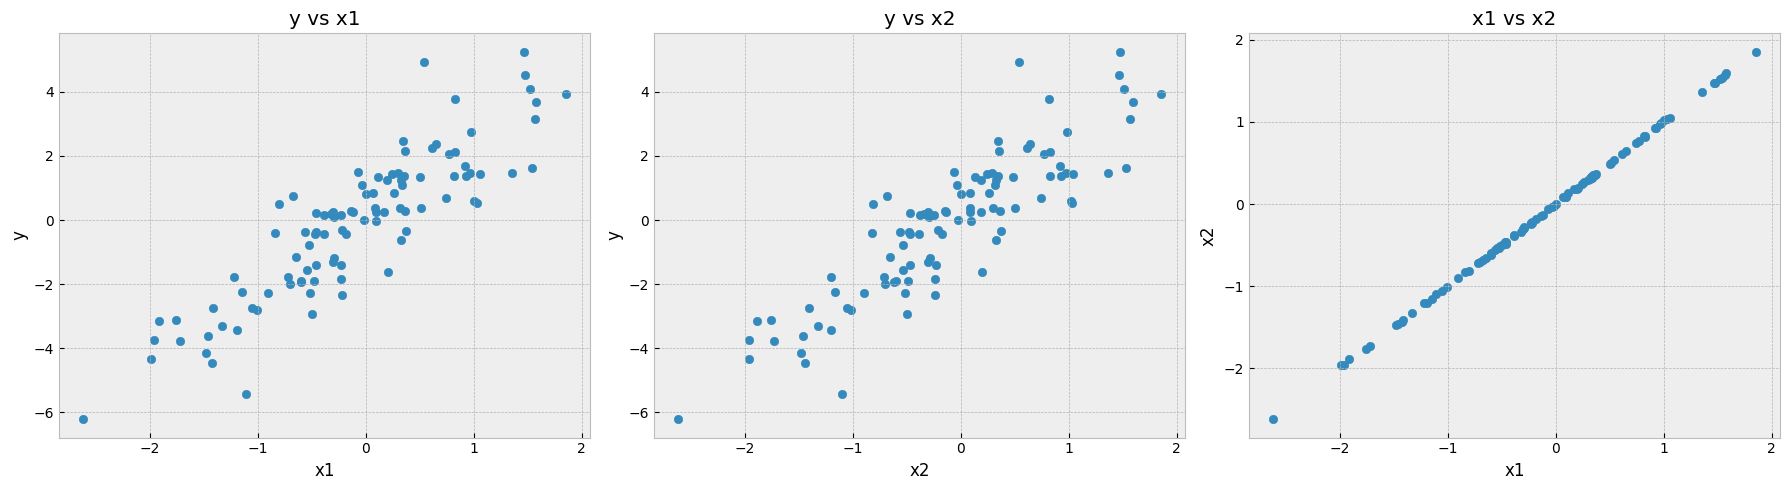

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.style.use('bmh')

# Make close to collinear data
np.random.seed(42)

x = np.random.normal(0, 1, 100)
x2 = x + np.random.normal(0, 0.01, 100)  # x2 is almost the same as x1
y = x + x2 + np.random.normal(0, 1, 100)
X = np.column_stack((x, x2))

# Plot 2 plots of y against x1 and x2
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.scatter(x, y)
plt.xlabel('x1')
plt.ylabel('y')
plt.title('y vs x1')

plt.subplot(1, 3, 2)
plt.scatter(x2, y)
plt.xlabel('x2')
plt.ylabel('y')
plt.title('y vs x2')

plt.subplot(1, 3, 3)
plt.scatter(x, x2)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('x1 vs x2')

plt.tight_layout()
plt.show()

In [2]:
# Fit the model
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     175.1
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           6.51e-33
Time:                        15:15:32   Log-Likelihood:                -147.62
No. Observations:                 100   AIC:                             301.2
Df Residuals:                      97   BIC:                             309.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0886      0.108      0.819      0.415      -0.126       0.303
x1             2.4538     11.422      0.215      0.830     -20.217      25.124
x2            -0.2277     11.438     -0.020      0.984     -22.929      22.474
==============================================================================
Omnibus:                        3.125   Durbin-Watson:                   2.220
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                3.080
Skew:                           0.108   Prob(JB):                        0.214
Kurtosis:                       3.832   Cond. No.                         195.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
# Shock x2 slightly and refit
x2 += np.random.normal(0, 0.01, 100)
X = np.column_stack((x, x2))
X_with_const = sm.add_constant(X)
model = sm.OLS(y, X_with_const).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     175.2
Date:                Sun, 07 Dec 2025   Prob (F-statistic):           6.37e-33
Time:                        15:15:32   Log-Likelihood:                -147.60
No. Observations:                 100   AIC:                             301.2
Df Residuals:                      97   BIC:                             309.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0869      0.109      0.801      0.425      -0.129       0.302
x1             0.4302      8.562      0.050      0.960     -16.563      17.423
x2             1.8018      8.588      0.210      0.834     -15.243      18.846
==============================================================================
Omnibus:                        3.204   Durbin-Watson:                   2.214
Prob(Omnibus):                  0.201   Jarque-Bera (JB):                3.212
Skew:                           0.106   Prob(JB):                        0.201
Kurtosis:                       3.852   Cond. No.                         146.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

My results are totally different! My x2 went from negative to positive, and my x1 went down by a lot even with just a tiny bit of noise.

What does this say about our estimator? It says that they have a lot of *variance*. Remember that OLS is BLUE, but it doesn't say anything about the variance of the estimator; it just says it's the lowest. 

Define model performance as:
$$
\text{MSE} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}
$$
This is the bias-variance tradeoff, lets look at each part:
- Bias: $E[\hat{f}(x)] - f(x)$; how far off from the truth we are on average
- Variance: $E[(\hat{f}(x) - E[\hat{f}(x)])^2]$; how much our estimate varies around its mean
- Irreducible Error: noise in the data that we can't do anything about

Remember from review 2 when I said that our $\beta$ has a variance, which is why we can do a t-test? Well, another way to write that variance is:

$$
\text{Var}(\hat{\beta}) = \frac{\sigma^2}{\sum_{i=1}^n (x_{ij} - \bar{x_j})^2} \cdot \frac{1}{1 - r_{j}^2}
$$

Where $r_j^2$ is the how much variance of our chosen feature, $x_j$, is explained by the other features. If we have collinearity, then $r_j^2$ is close to 1, and our variance explodes.

This final term is called the variance inflation factor (VIF), and it tells us how much the variance of our estimator is inflated by collinearity.

So we want to minimze both bias and variance, but they are typically in tension with each other. If we make our model more complex, we might reduce bias but increase variance. If we make it simpler, we might reduce variance but increase bias.

Therefore, regularization is a way to add some bias into our model, in order to reduce variance. Note that BLUE only applies to unbiased estimators, so adding bias might result in lower variance (in the extreme, if we just guess "1" for everything, we have zero variance in our estimator, but high bias).

One way to think about this is that we want to penalize large coefficients. If we have a lot of features, we want to shrink the coefficients of the less important ones towards zero, so that we can keep the most important ones. This is the idea behind Ridge and LASSO regression.


#### Ridge Regression

Ridge regression adds a penalty to the OLS objective function that is proportional to the square of the coefficients. The objective function for Ridge regression is:
$$
\min_{\beta} \|y - X\beta\|^2_2 + \lambda \|\beta\|^2_2
$$


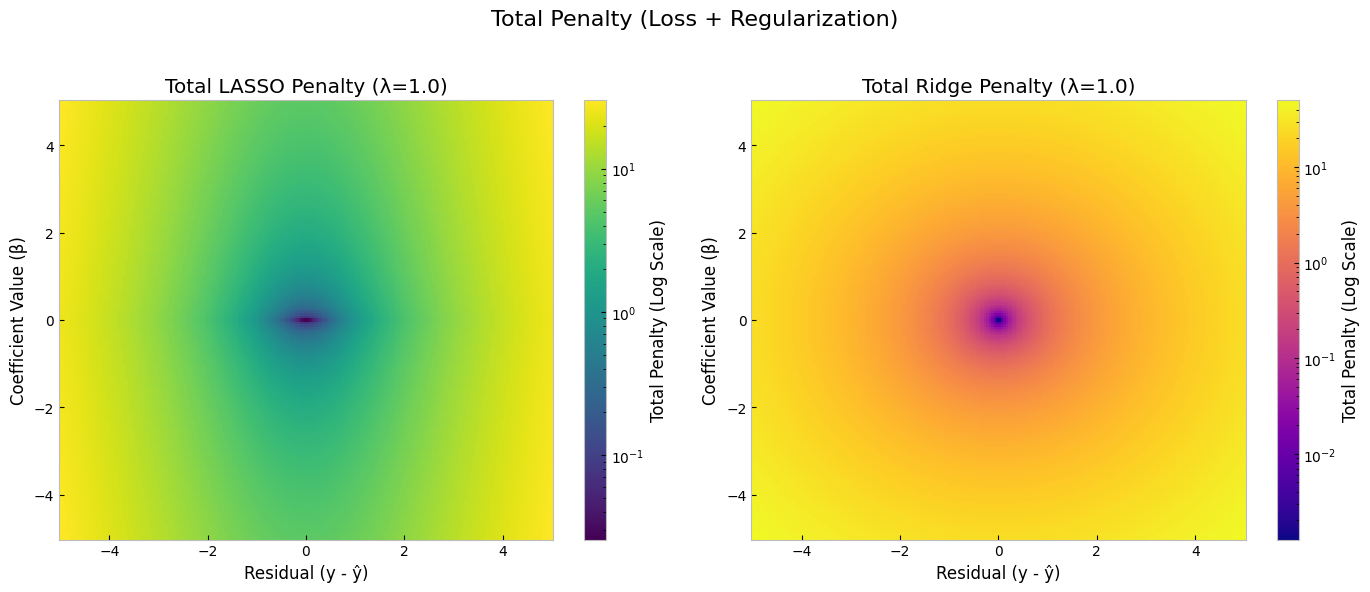

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# --- Part 1: Loss Functions (Penalty on Residuals) ---

# Generate a range of residual values (y - y_hat)
residuals_1d = np.linspace(-10, 10, 500)

# 1. Squared Error (L2 Loss)
squared_error = residuals_1d**2

# 2. Absolute Error (L1 Loss)
absolute_error = np.abs(residuals_1d)

# Generate ranges for residuals and coefficient values
residuals_2d = np.linspace(-5, 5, 200)
beta_values = np.linspace(-5, 5, 200)
lambda_param = 1.0 # Regularization strength parameter

# Create a meshgrid to evaluate the penalty at each point
R, B = np.meshgrid(residuals_2d, beta_values)

# Calculate the base loss (Squared Error) across the grid
loss_grid = R**2

# 1. Total LASSO Penalty (Loss + L1 Regularization)
total_lasso_penalty = loss_grid + (lambda_param * np.abs(B))

# 2. Total Ridge Penalty (Loss + L2 Regularization)
total_ridge_penalty = loss_grid + (lambda_param * B**2)

# Create the plot for Regularization Penalty Heatmaps
fig2, axs2 = plt.subplots(1, 2, figsize=(14, 6))
fig2.suptitle('Total Penalty (Loss + Regularization)', fontsize=16)

# Plot LASSO Penalty Heatmap
im1 = axs2[0].pcolormesh(R, B, total_lasso_penalty, cmap='viridis', norm=LogNorm())
axs2[0].set_title(f'Total LASSO Penalty (λ={lambda_param})')
axs2[0].set_xlabel('Residual (y - ŷ)')
axs2[0].set_ylabel('Coefficient Value (β)')
axs2[0].grid(False)
fig2.colorbar(im1, ax=axs2[0], label='Total Penalty (Log Scale)')

# Plot Ridge Penalty Heatmap
im2 = axs2[1].pcolormesh(R, B, total_ridge_penalty, cmap='plasma', norm=LogNorm())
axs2[1].set_title(f'Total Ridge Penalty (λ={lambda_param})')
axs2[1].set_xlabel('Residual (y - ŷ)')
axs2[1].set_ylabel('Coefficient Value (β)')
axs2[1].grid(False)
fig2.colorbar(im2, ax=axs2[1], label='Total Penalty (Log Scale)')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


The idea is that we're discouraging large coefficients. Note that $\lambda$ is a hyperparameter (which so far we have not discussed) that controls the strength of the penalty. When $\lambda = 0$, we get back the OLS solution. As $\lambda$ increases, the coefficients are shrunk towards zero.

Also note that this penalty is differentiable! So ridge regression has a closed form solution:
$$
\hat{\beta}_{ridge} = (X^TX + \lambda I)^{-1}X^Ty
$$

Lets explore what that looks like visually, with 10 different variables that are all correlated with each other.

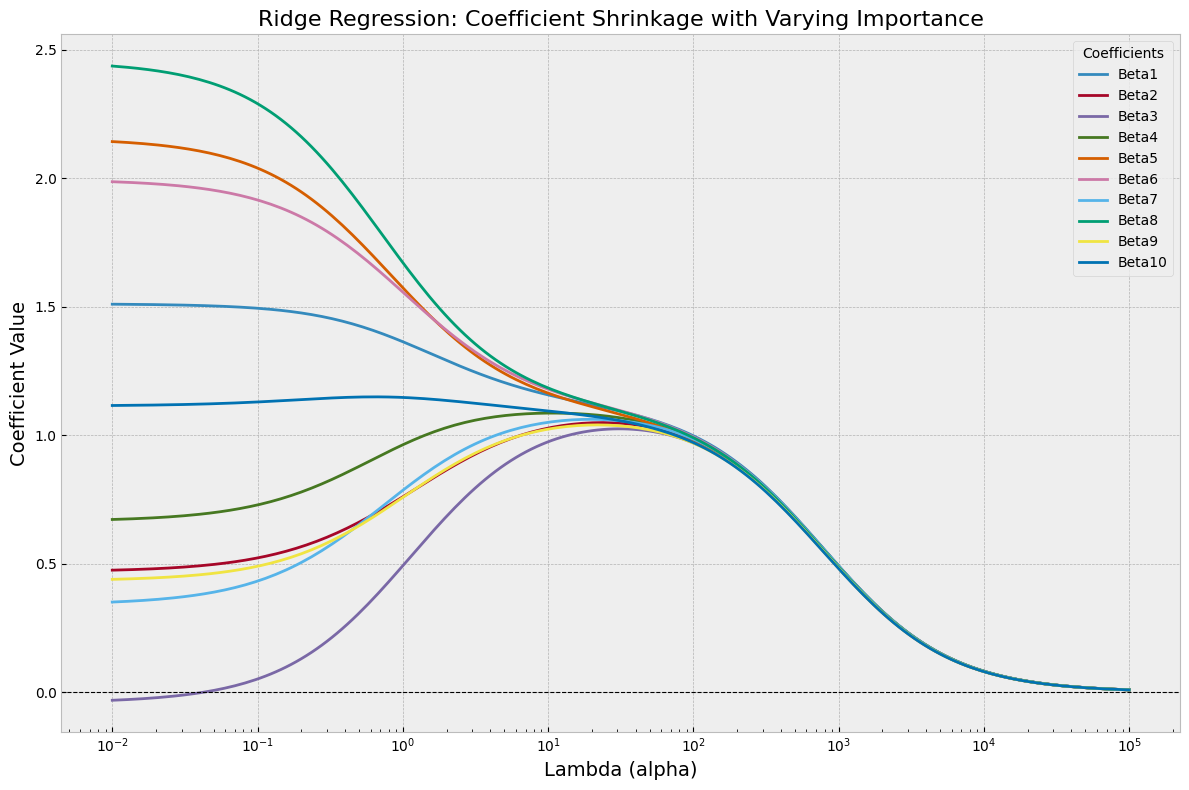

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# --- 1. Generate the correlated data as specified ---
n_samples = 100
n_features = 10
np.random.seed(42) # for reproducibility

# Create a covariance matrix where all variables have a correlation of 0.8
# The variance of each variable is 1 (0.8 + 0.2)
cov_matrix = np.full((n_features, n_features), 0.99) + np.diag(np.full(n_features, 0.01))

# Generate the predictor variables
X = np.random.multivariate_normal(
    mean=np.zeros(n_features),
    cov=cov_matrix,
    size=n_samples
)

# --- MODIFIED Y ---
# Generate the response variable where Beta 1 is more important (true value = 2)
true_betas = np.ones(n_features)
true_betas[0] = 2  # Set the first coefficient to be larger
y = X @ true_betas + np.random.normal(0, 1, n_samples)


# --- 2. Set up the Ridge Regression analysis ---

# Create a wide range of lambda (alpha) values to test
# np.logspace creates values evenly spaced on a log scale
alphas = np.logspace(-2, 5, 200)

# Array to store the coefficients for each alpha
coefficients = []

# Loop through each alpha value, fit the model, and store the coefficients
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X, y)
    coefficients.append(ridge.coef_)

# Convert the list of coefficients into a NumPy array for easier plotting
coefficients = np.array(coefficients)


fig, ax = plt.subplots(figsize=(12, 8))

# Plot the most important coefficient (Beta 1) with a thicker, distinct line
# ax.plot(alphas, coefficients[:, 0], label=f'Beta 1 (True=2)', linewidth=3, color='red', zorder=10)

# Plot the other coefficients with a lighter color
for i in range(0, n_features):
    ax.plot(alphas, coefficients[:, i], alpha=1, label=f'Beta{i+1}')

# Use a logarithmic scale for the x-axis for better visualization
ax.set_xscale('log')

# Add labels, title, and legend
ax.set_xlabel('Lambda (alpha)', fontsize=14)
ax.set_ylabel('Coefficient Value', fontsize=14)
ax.set_title('Ridge Regression: Coefficient Shrinkage with Varying Importance', fontsize=16)
ax.legend(title='Coefficients', loc='upper right')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8) # Add a line at y=0

plt.tight_layout()
plt.show()

The idea behind Ridge is to not drop features, but rather to shrink their coefficients to make them much more stable. If we think about it this makes sense:

$$
\hat{\beta}_{ridge} = (X^TX + \lambda I)^{-1}X^Ty
$$

Note that the instability comes from the $X^TX$ term, which means that for very small changes in the data, we might have large changes in the estimated coefficients. By adding $\lambda I$, we are making it more stable (lowering the condition number of the matrix). Lets see how this looks in practice.

In [6]:
# Calculate X^TX and its condition number
XTX = X.T @ X
condition_number = np.linalg.cond(XTX)
print(f"Condition number of X^TX: {condition_number:.2f}")

# Print with lambda = 10 condition number
lambda_ = 10
XTX_ridge = XTX + lambda_ * np.eye(XTX.shape[0])
condition_number_ridge = np.linalg.cond(XTX_ridge)
print(f"Condition number of X^TX with lambda = {lambda_}: {condition_number_ridge:.2f}")

Condition number of X^TX: 1687.79
Condition number of X^TX with lambda = 10: 75.94


This is outside of the scope of this review, but Chapter 3 of Elements of Statistical Learning has a very good discussion of some different ways to think about ridge regresion.

#### LASSO Regression

LASSO regression adds a penalty to the OLS objective function that is proportional to the absolute value of the coefficients. The objective function for LASSO regression is:
$$
\min_{\beta} \|y - X\beta\|^2_2 + \lambda \|\beta\|_1
$$

Unfortunately, not differentiable, so we need to use an algorithm to solve it. The idea is that we're discouraging large coefficients, but also trying to "kill" some of them by forcing them to be exactly zero.

A good way to visualize this is to think about the contours of the objective function. The contours of the OLS objective function are ellipses, while the contours of the LASSO objective function are diamonds. The intersection of the two is where the solution lies, and it tends to hit the axes more often than not, which means that some coefficients are exactly zero.

![image](contour_plot.png)

The good thing about to LASSO is that we can perform feature selection, since it will set some coefficients to zero!

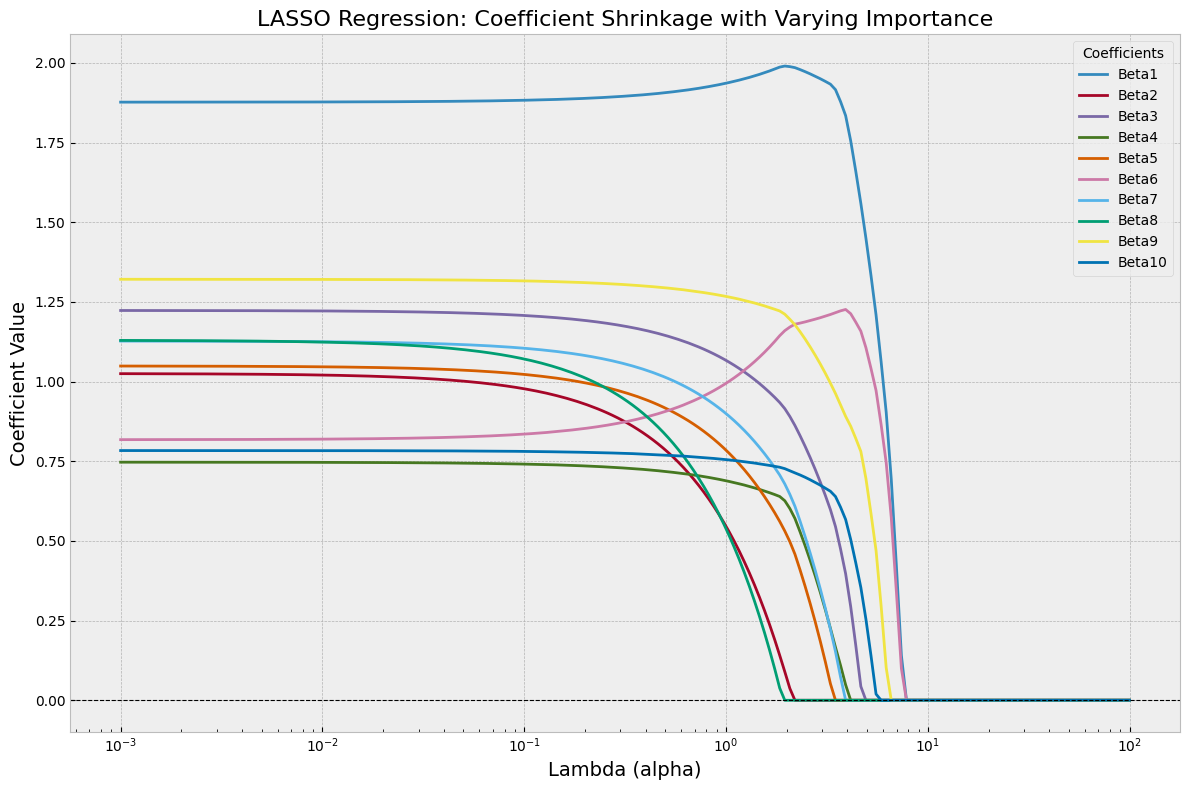

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# --- 1. Generate the correlated data as specified ---
n_samples = 100
n_features = 10
np.random.seed(42) # for reproducibility

# Create a covariance matrix where all variables have a correlation of 0.8
# The variance of each variable is 1 (0.8 + 0.2)
cov_matrix = np.full((n_features, n_features), 0.8) + np.diag(np.full(n_features, 0.2))

# Generate the predictor variables
X = np.random.multivariate_normal(
    mean=np.zeros(n_features),
    cov=cov_matrix,
    size=n_samples
)

# Generate the response variable where Beta 1 is more important (true value = 2)
true_betas = np.ones(n_features)
true_betas[0] = 2  # Set the first coefficient to be larger
y = X @ true_betas + np.random.normal(0, 1, n_samples)


# --- 2. Set up the LASSO Regression analysis ---

# Create a wide range of lambda (alpha) values to test
# np.logspace creates values evenly spaced on a log scale
alphas = np.logspace(-3, 2, 200)

# Array to store the coefficients for each alpha
coefficients = []

# Loop through each alpha value, fit the model, and store the coefficients
for alpha in alphas:
    # Use Lasso instead of Ridge
    lasso = Lasso(alpha=alpha, max_iter=10000) 
    lasso.fit(X, y)
    coefficients.append(lasso.coef_)

# Convert the list of coefficients into a NumPy array for easier plotting
coefficients = np.array(coefficients)

fig, ax = plt.subplots(figsize=(12, 8))


# Plot the other coefficients with a lighter color
for i in range(n_features):
    ax.plot(alphas, coefficients[:, i],label=f'Beta{i+1}')

# Use a logarithmic scale for the x-axis for better visualization
ax.set_xscale('log')

# Add labels, title, and legend
ax.set_xlabel('Lambda (alpha)', fontsize=14)
ax.set_ylabel('Coefficient Value', fontsize=14)
ax.set_title('LASSO Regression: Coefficient Shrinkage with Varying Importance', fontsize=16)
ax.legend(title='Coefficients', loc='upper right')
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8) # Add a line at y=0

plt.tight_layout()
plt.show()


#### Elastic Net

Elastic Net is just a combination of Ridge and LASSO. The objective function is:
$$
\min_{\beta} \|y - X\beta\|^2_2 + \lambda_1 \|\beta\|_1 + \lambda_2 \|\beta\|^2_2
$$

So we have two hyperparameters to tune, $\lambda_1$ and $\lambda_2$. This allows us to get the best of both worlds: we can shrink coefficients towards zero, but also set some of them to exactly zero. This also gives us an additional headache of tuning two hyperparameters instead of one.

#### Hyperparameter Tuning and Cross-Validation

Typically, the way that we tune hyperparameters is through cross-validation. We split the data into $k$ different sets, and then we train the model on $k-1$ sets and test it on the remaining set. We do this $k$ times, each time using a different set as the test set. We then average the performance across all $k$ sets to determine the best hyperparameter.

The issue with financial data is that it is illegal to do this :(

Financial data is a time series, which means that can easily induce look-ahead bias if we aren't careful. 

Therefore, the way that we can do cross-validation is through a rolling window approach. Where instead of randomly splitting the data, we split it based on time. For instance, if we had 10 years of data we would first train the model on year 1, then test it on year 2. Then we would train the model on years 1 and 2, and test it on year 3. We would continue this process until we have tested on all years.

#### Robust Regression

Robust regression is a way to deal with outliers in the data.

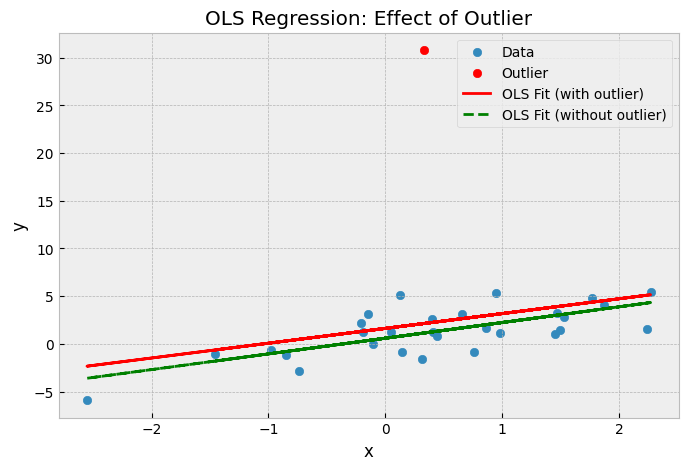

In [8]:
# Create data with an outlier
np.random.seed(0)
x = np.random.normal(0, 1, 30)
y = 2 * x + 1 + np.random.normal(0, 2, size=x.shape)
y[15] += 30  # Add a large outlier

# Fit OLS regression with outlier
X_ols = sm.add_constant(x)
model_ols = sm.OLS(y, X_ols).fit()

# Fit OLS regression without the outlier
mask = np.arange(len(x)) != 15
X_ols_no = sm.add_constant(x[mask])
model_ols_no = sm.OLS(y[mask], X_ols_no).fit()

# Plot data
plt.figure(figsize=(8, 5))
plt.scatter(x[mask], y[mask], label='Data', color='C0')
plt.scatter(x[15], y[15], color='red', label='Outlier', zorder=10)
plt.plot(x, model_ols.predict(X_ols), color='red', label='OLS Fit (with outlier)')
plt.plot(x, model_ols_no.predict(sm.add_constant(x)), color='green', linestyle='--', label='OLS Fit (without outlier)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('OLS Regression: Effect of Outlier')
plt.legend()
plt.show()

Review question, if I wanted to make this example have an "outsized" impact on the slope of the regression, what should I do?

We see from above that an outlier point can potentially have a big impact on our coefficients. The question then becomes, how should we deal with this? What might we use from last class?

It does seem kind of suspicious to just drop data points, so maybe we should use a loss function that is less sensitive to outliers.

#### Huber Loss

Huber loss is a mix of squared loss and absolute loss. It is defined as:
$$
L_{\delta}(y, f(x)) =
\begin{cases}
\frac{1}{2}(y - f(x))^2 & \text{if } |y - f(x)| \leq \delta \\
\delta(|y - f(x)| - \frac{1}{2}\delta) & \text{otherwise}
\end{cases}
$$

Where $\delta$ is a hyperparameter that controls the transition point between the two functions.

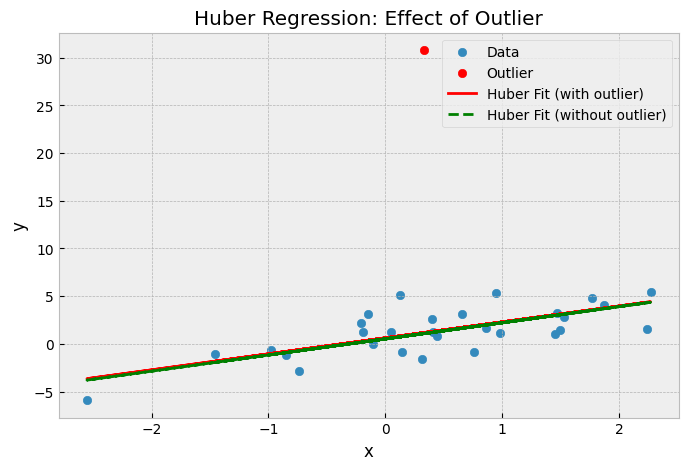

In [9]:
from sklearn.linear_model import HuberRegressor

# Fit Huber regression with outlier
huber_with_outlier = HuberRegressor().fit(x.reshape(-1, 1), y)
y_pred_huber_with = huber_with_outlier.predict(x.reshape(-1, 1))

# Fit Huber regression without the outlier
huber_no_outlier = HuberRegressor().fit(x[mask].reshape(-1, 1), y[mask])
y_pred_huber_no = huber_no_outlier.predict(x.reshape(-1, 1))

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x[mask], y[mask], label='Data', color='C0')
plt.scatter(x[15], y[15], color='red', label='Outlier', zorder=10)
plt.plot(x, y_pred_huber_with, color='red', label='Huber Fit (with outlier)')
plt.plot(x, y_pred_huber_no, color='green', linestyle='--', label='Huber Fit (without outlier)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Huber Regression: Effect of Outlier')
plt.legend()
plt.show()

Pretty good! Choosing which loss function to use is a little hard (and remember! multiple comparisons!). Note that Huber loss still puts *some* weight on outlier, and that weight increases as the outlier gets further away. So, potentially, we might think that we should instead "cap" the maximum penalty for any one point.

#### Tukey's Biweight Loss

Tukey loss is another flavor of loss function, only unlike Huber loss, it caps the weight of an outlier.

Tukey's Biweight loss is defined as:
$$
L_T(c, y, f(x)) =
\begin{cases}
\frac{c^2}{6} \left(1 - \left(1 - \left(\frac{y - f(x)}{c}\right)^2\right)^3\right) & \text{if } |y - f(x)| < c \\
\frac{c^2}{6} & \text{otherwise}
\end{cases}
$$

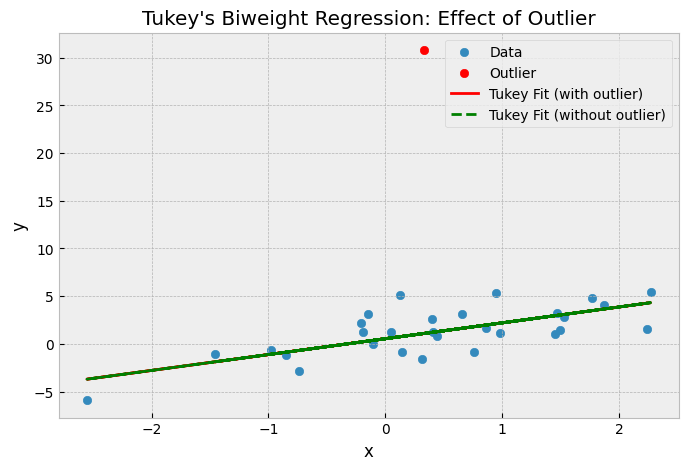

In [10]:
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.robust.norms import TukeyBiweight

import statsmodels.api as sm

# Fit Tukey Biweight robust regression with outlier
model_tukey_with = RLM(y, sm.add_constant(x), M=TukeyBiweight()).fit()
y_pred_tukey_with = model_tukey_with.predict(sm.add_constant(x))

# Fit Tukey Biweight robust regression without the outlier
model_tukey_no = RLM(y[mask], sm.add_constant(x[mask]), M=TukeyBiweight()).fit()
y_pred_tukey_no = model_tukey_no.predict(sm.add_constant(x))

# Plot
plt.figure(figsize=(8, 5))
plt.scatter(x[mask], y[mask], label='Data', color='C0')
plt.scatter(x[15], y[15], color='red', label='Outlier', zorder=10)
plt.plot(x, y_pred_tukey_with, color='red', label='Tukey Fit (with outlier)')
plt.plot(x, y_pred_tukey_no, color='green', linestyle='--', label='Tukey Fit (without outlier)')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Tukey's Biweight Regression: Effect of Outlier")
plt.legend()
plt.show()

What might be an issue with these loss functions? Well, we lose inference. Specifically, a lot of the inference that we can do with OLS relies on the specific choice of squared loss. The benefit, though, is that we're able to deal with outliers in a better way than just dropping them.

Another thing to keep in mind is that we just added more complexity. Now we have to do additional validation to choose the hyperparameters, and so overfitting becomes even more important.

#### Time Series

Time series are special because:
1. They are ordered in time, so we can't just randomly split the data
2. Observations may not be independent
3. Our "X" variable kind of exists for us, it's just the time index

With that being said, a lot of what we just talked about also applies to time series. 

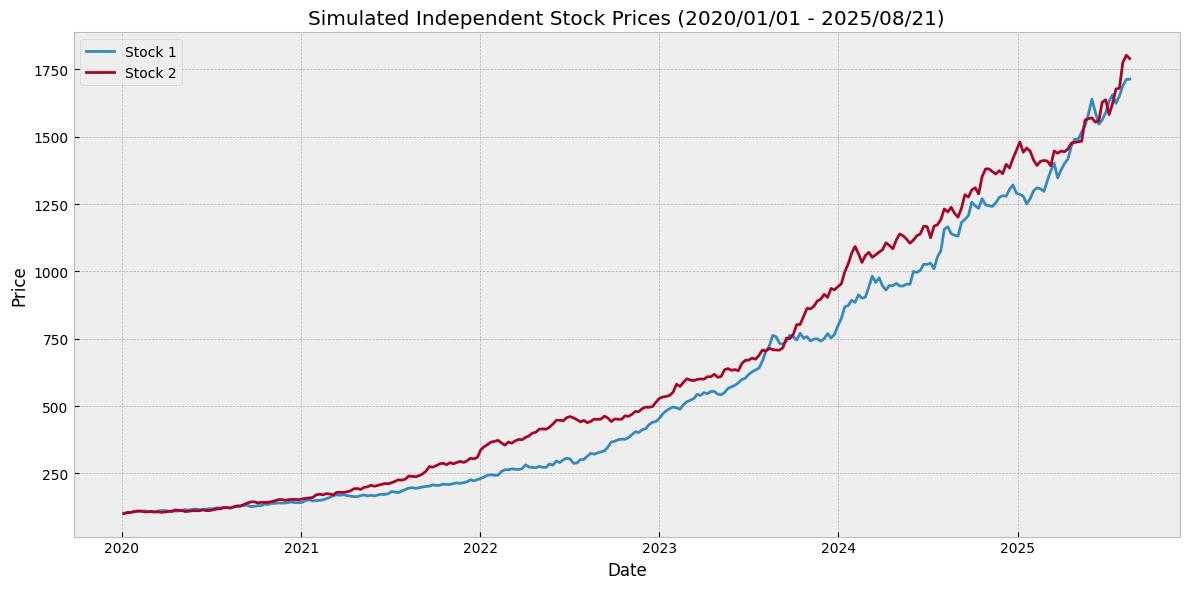

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate date range for business days
dates = pd.date_range(start="2020-01-01", end="2025-08-21", freq="W")
n_days = len(dates)

# Simulate two independent stocks with positive mean return
np.random.seed(42)

returns = np.random.multivariate_normal(
    mean=[0.01, 0.01],  # Mean returns for both stocks
    cov=[[0.02**2, 0], [0, 0.02**2]],  # Independent covariance
    size=n_days
)

returns1 = returns[:, 0]
returns2 = returns[:, 1]
price1 = 100 * np.exp(np.cumsum(returns1))
price2 = 100 * np.exp(np.cumsum(returns2))

# Create DataFrame
stock_df = pd.DataFrame({
    'Price_Stock1': price1,
    'Price_Stock2': price2
}, index=dates)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(stock_df.index, stock_df['Price_Stock1'], label='Stock 1')
plt.plot(stock_df.index, stock_df['Price_Stock2'], label='Stock 2')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Simulated Independent Stock Prices (2020/01/01 - 2025/08/21)')
plt.legend()
plt.tight_layout()
plt.show()

Let's suppose that we have these two time series, and we want to model the relationship between them. One thing we might want to do is to use the correlation between them.

In [12]:
stock_df.corr()

,Price_Stock1,Price_Stock2
Price_Stock1,1.000000,0.993456
Price_Stock2,0.993456,1.000000


They're 99% correlated...so maybe let's try lagging one of them and trying to predict the other.

In [13]:
forecast_df = stock_df.copy()
forecast_df['Lagged_Stock1'] = forecast_df['Price_Stock1'].shift(1)

# Fit OLS regression with lagged variable
X_forecast = sm.add_constant(forecast_df[['Lagged_Stock1']])
y_forecast = forecast_df['Price_Stock2']
model_forecast = sm.OLS(y_forecast, X_forecast, missing='drop').fit()
model_forecast.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Price_Stock2   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.225e+04
Date:                Sun, 07 Dec 2025   Prob (F-statistic):          6.37e-277
Time:                        15:15:33   Log-Likelihood:                -1590.8
No. Observations:                 293   AIC:                             3186.
Df Residuals:                     291   BIC:                             3193.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            50.3331      5.145      9.782      0.000      40.206      60.460
Lagged_Stock1     1.0384      0.007    149.173      0.000       1.025       1.052
==============================================================================
Omnibus:                        0.620   Durbin-Watson:                   0.157
Prob(Omnibus):                  0.733   Jarque-Bera (JB):                0.745
Skew:                          -0.074   Prob(JB):                        0.689
Kurtosis:                       2.802   Cond. No.                     1.18e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.18e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Incredible, we have a 99% r-squared. Are we going to be the next Jim Simons?

#### Stationarity

Unfortunately not. What's going on is that we're using *prices*, and these prices are trending upward over time. That means that if I ask what the price is going to be tomorrow, I can just look at the price today and it's going to be very close. Similarly, these stocks look extremely correlated because they're both trending up over time (eg. if one is close to $100, the other might be close to $100).

This problem is called stationarity. A time series is considered stationary if its properties do not change over time (eg. mean and variance). Normally charts are a good way to visualize this.

So, instead of using prices, maybe we should use difference in prices. 

$$
\Delta P_t = P_t - P_{t-1}
$$


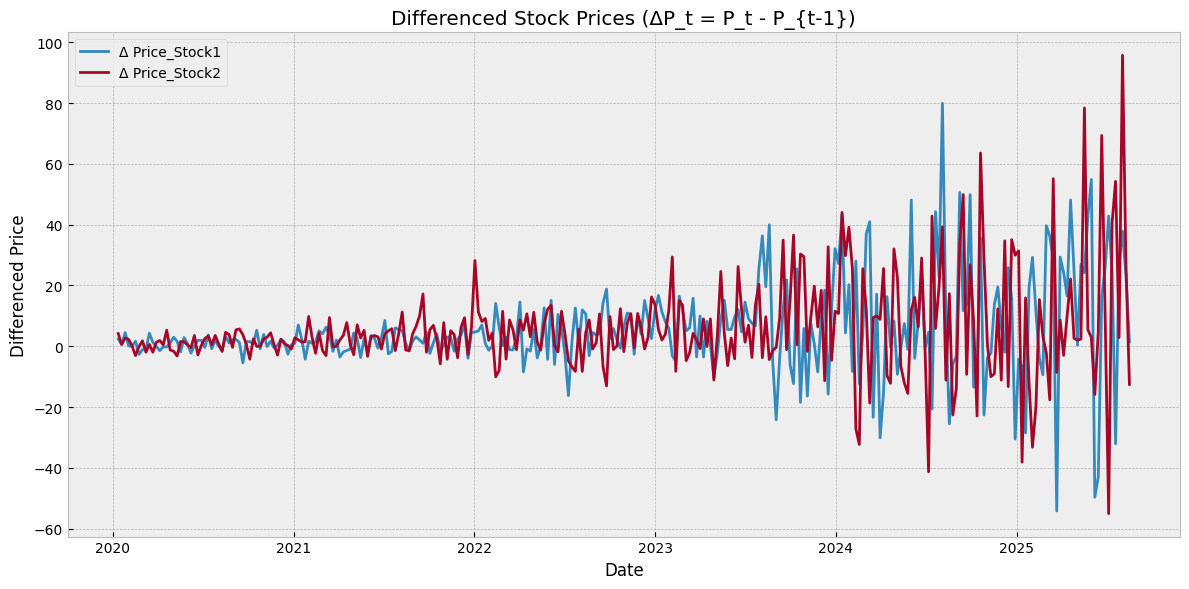

,Price_Stock1,Price_Stock2
Price_Stock1,1.0000,0.1184
Price_Stock2,0.1184,1.0000


In [14]:
diff_stock_df = stock_df.diff().dropna()

plt.figure(figsize=(12, 6))
plt.plot(diff_stock_df.index, diff_stock_df['Price_Stock1'], label='Δ Price_Stock1')
plt.plot(diff_stock_df.index, diff_stock_df['Price_Stock2'], label='Δ Price_Stock2')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.title('Differenced Stock Prices (ΔP_t = P_t - P_{t-1})')
plt.legend()
plt.tight_layout()
plt.show()
diff_stock_df.corr()

Okay, so it looks like the prices are centered. But we have this explosion in variance as the price go up. This means again that our time series is not stationary, because the variance is changing over time.

Therefore, the typical fix in finance involves using either returns or log returns.

$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$
$$
R_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$

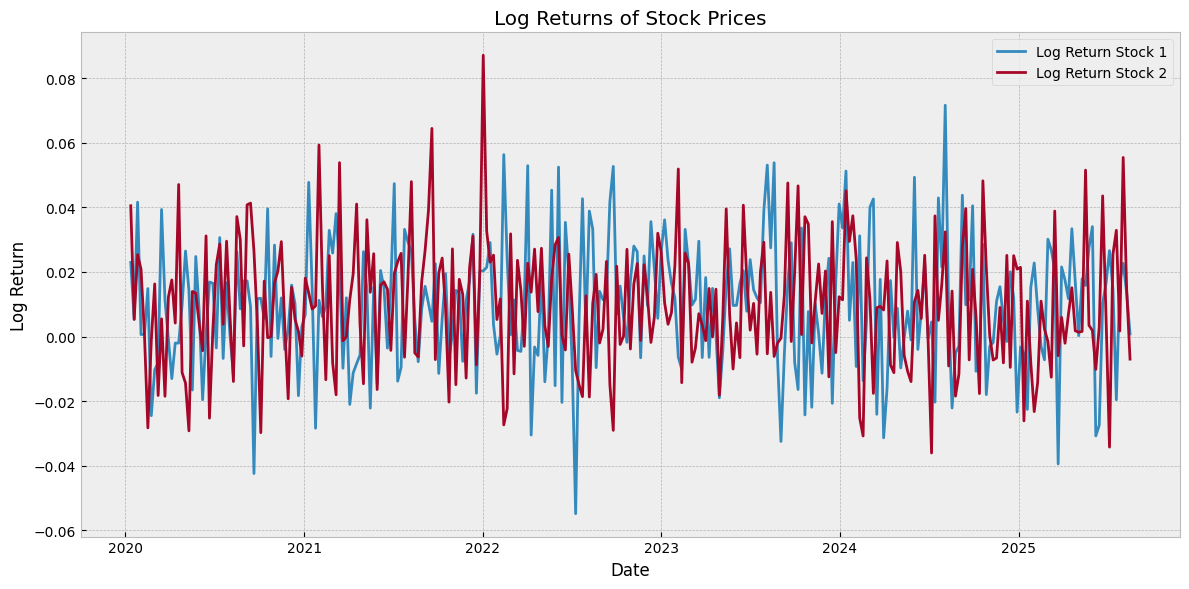

In [15]:
# Calculate log returns for both stocks
log_returns = np.log(stock_df / stock_df.shift(1)).dropna()

# Plot log returns
plt.figure(figsize=(12, 6))
plt.plot(log_returns.index, log_returns['Price_Stock1'], label='Log Return Stock 1')
plt.plot(log_returns.index, log_returns['Price_Stock2'], label='Log Return Stock 2')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.title('Log Returns of Stock Prices')
plt.legend()
plt.tight_layout()
plt.show()

It looks like we have a stationary time series, lets go back and try our correlation and regression again.

In [16]:
log_returns.corr()

,Price_Stock1,Price_Stock2
Price_Stock1,1.000000,0.017586
Price_Stock2,0.017586,1.000000


In [17]:
forecast_df_log = log_returns.copy()
forecast_df_log['Lagged_Stock1'] = forecast_df_log['Price_Stock1'].shift(1)

model = sm.OLS(forecast_df_log['Price_Stock1'], sm.add_constant(forecast_df_log[['Lagged_Stock1']]), missing='drop').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Price_Stock1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                 2.172e-05
Date:                Sun, 07 Dec 2025   Prob (F-statistic):              0.996
Time:                        15:15:33   Log-Likelihood:                 732.19
No. Observations:                 292   AIC:                            -1460.
Df Residuals:                     290   BIC:                            -1453.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0096      0.001      7.432      0.000       0.007       0.012
Lagged_Stock1     0.0003      0.059      0.005      0.996      -0.115       0.116
==============================================================================
Omnibus:                        0.493   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.781   Jarque-Bera (JB):                0.268
Skew:                           0.014   Prob(JB):                        0.875
Kurtosis:                       3.146   Cond. No.                         50.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

That's much better; these two time series were made to be independent, so we should expect them to be uncorrelated.

We can also more formally test for stationary using something like an Augmented Dickey-Fuller (ADF) test.

#### Autoregressive Models

One way we might want to model a time series is that we might think that the current value of a time series depends on its past values. This is called an autoregressive model, and it is defined as:

$$
y_t = \beta_0 + \beta_1 y_{t-1} + \beta_2 y_{t-2} + ... + \beta_p y_{t-p} + \epsilon_t
$$

Where $p$ is the number of lags that we want to include in the model. The simplest of these is the AR(1) model, which is just:
$$y_t = \beta_0 + \beta_1 y_{t-1} + \epsilon_t$$

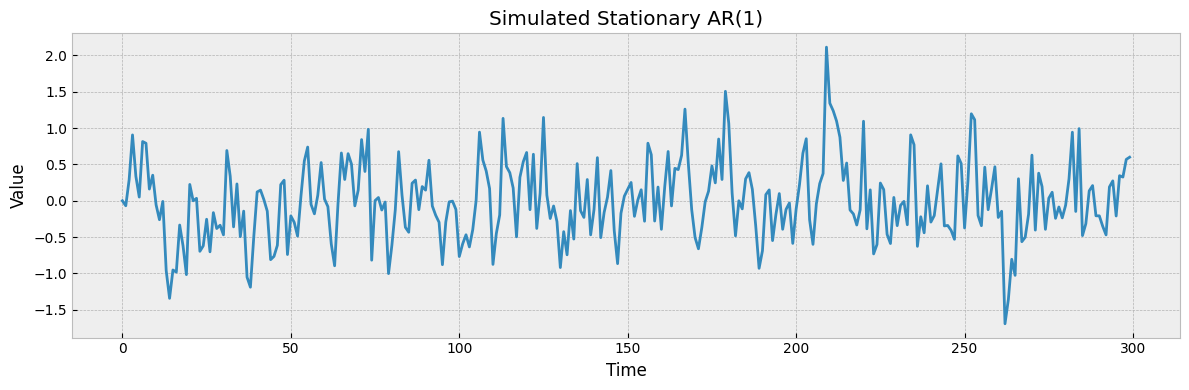

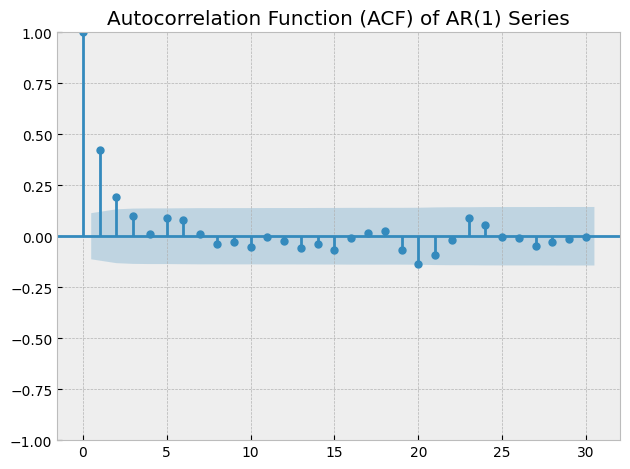

In [18]:
import numpy as np
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

# Generate a stationary AR(1) process with autocorrelation
np.random.seed(42)
n = 300
phi = 0.5  # AR(1) coefficient, |phi| < 1 ensures stationarity
noise = np.random.normal(0, 0.5, n)
ar1_series = np.zeros(n)
for t in range(1, n):
    ar1_series[t] = phi * ar1_series[t-1] + noise[t]

# Plot the time series
plt.figure(figsize=(12, 4))
plt.plot(ar1_series)
plt.title('Simulated Stationary AR(1)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

# Plot the autocorrelation function
plot_acf(ar1_series, lags=30)
plt.title('Autocorrelation Function (ACF) of AR(1) Series')
plt.tight_layout()
plt.show()

In [19]:
from statsmodels.tsa.ar_model import AutoReg

model_ar1 = AutoReg(ar1_series, lags=1)
model_ar1_fit = model_ar1.fit()
model_ar1_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  300
Model:                     AutoReg(1)   Log Likelihood                -211.145
Method:               Conditional MLE   S.D. of innovations              0.490
Date:                Sun, 07 Dec 2025   AIC                            428.291
Time:                        15:15:34   BIC                            439.392
Sample:                             1   HQIC                           432.734
                                  300                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0044      0.028     -0.156      0.876      -0.060       0.051
y.L1           0.4268      0.052      8.139      0.000       0.324       0.530
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3431           +0.0000j            2.3431            0.0000
-----------------------------------------------------------------------------
"""

You'll notice that I'm using the `AutoReg` class from `statsmodels`, this is just to be precise in the confidence intervals, since inference is a little tricker with time series.

Note that our regular diagnostic plots for regression still apply! So we can check if the residuals are i.i.d.

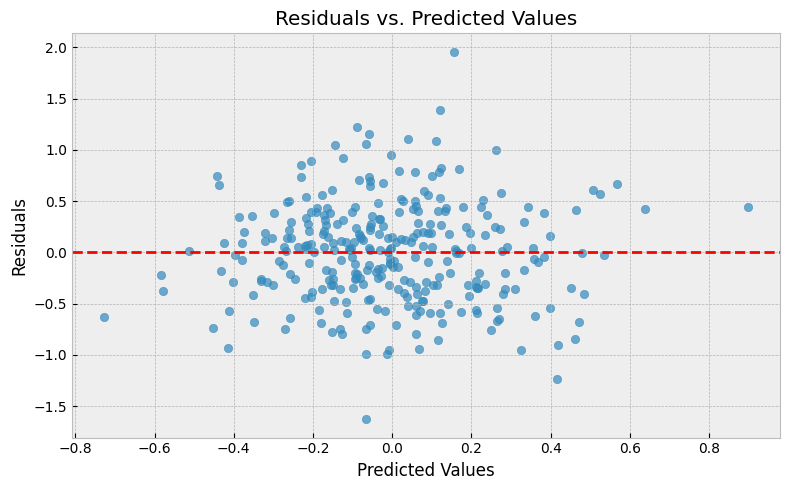

In [20]:
# Calculate predicted values and residuals for OLS model from cell 3
y_pred = model_ar1_fit.predict()
residuals = ar1_series - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.tight_layout()
plt.show()

This time series was stationary. What about if the mean itself is changing over time?

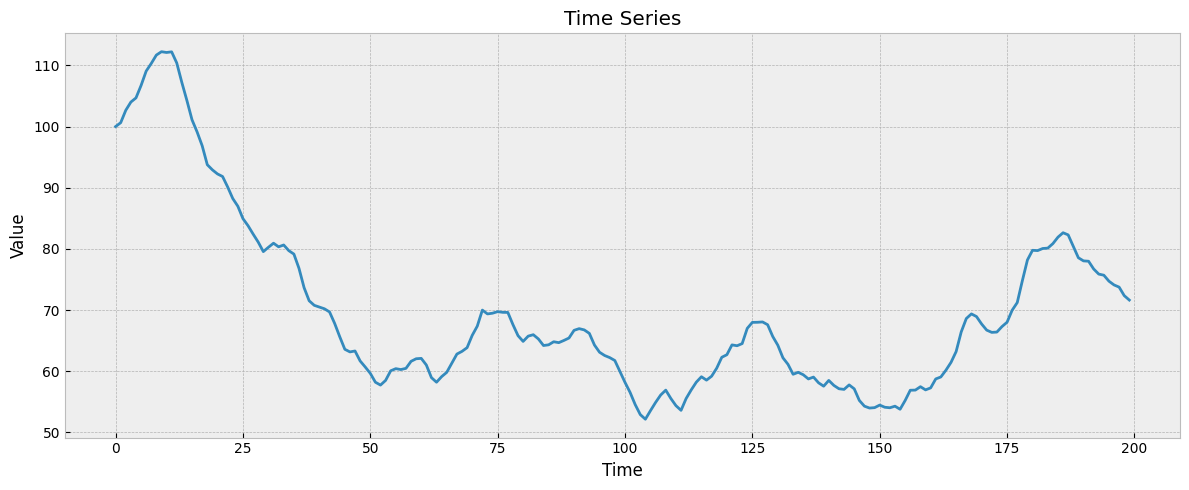

In [21]:
import numpy as np

import matplotlib.pyplot as plt

# Simulate an ARIMA(1,1,1) process
np.random.seed(42)
n = 200
ar = 0.7   # AR(1) coefficient
ma = 0.1# MA(1) coefficient

# Generate white noise
e = np.random.normal(0, 1, n+1)

# Simulate ARIMA(1,1,1): y_t = y_{t-1} + ar*(y_{t-1} - y_{t-2}) + e_t + ma*e_{t-1}
y = np.zeros(n+1) + 100

for t in range(2, n+1):
    y[t] = y[t-1] + ar*(y[t-1] - y[t-2]) + e[t] + ma*e[t-1]

plt.figure(figsize=(12, 5))
plt.plot(y[1:])
plt.xlabel('Time')
plt.ylabel('Value')

plt.title('Time Series')
plt.tight_layout()
plt.show()

Lets try differencing it.

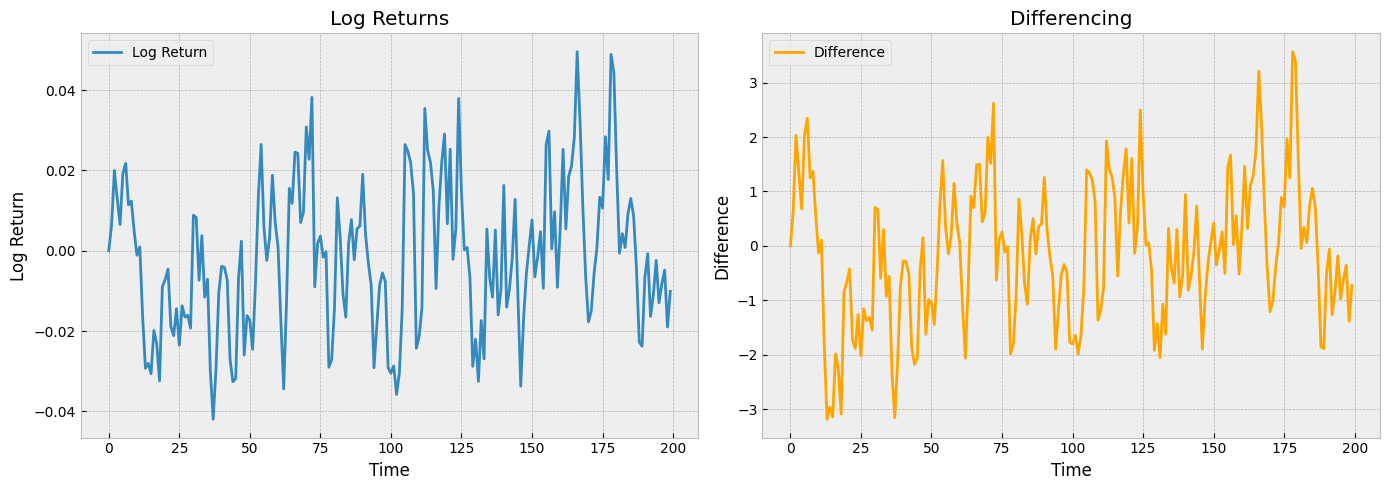

In [22]:
plt.figure(figsize=(14, 5))

# Left: log returns of ARIMA process
plt.subplot(1, 2, 1)
log_returns_arima = np.log(y[1:] / y[:-1])
plt.plot(log_returns_arima, label='Log Return')
plt.xlabel('Time')
plt.ylabel('Log Return')
plt.title('Log Returns')
plt.legend()

# Right: difference of ARIMA process
plt.subplot(1, 2, 2)
diff_arima = np.diff(y)
plt.plot(diff_arima, label='Difference', color='orange')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Differencing')
plt.legend()

plt.tight_layout()
plt.show()


It looks...okay, but there are periods of time where we're still trending up or down, so simple differencing doesn't work. We could account for this by using a moving average, to capture the "trending" behavior that we see in the data. Note that this isn't super common in finance (since we just use log returns and normally get stationary-ish data).

#### ARIMA

ARIMA stands for AutoRegressive Integrated Moving Average, and it is a generalization of the AR model that includes an AR component, and a moving average component. 


For the ARIMA(1,1,1) model, it would look like this:
$$
y_t = (1 + \phi_1)y_{t - 1} - \phi_1 y_{t - 2} + \epsilon_t + \theta_1 \epsilon_{t - 1}
$$
Note that this does the differencing for us, so we don't need to do it manually. The $\phi$ terms are the autoregressive coefficients, and the $\theta$ terms are the moving average coefficients.

In [23]:
# Fit ARIMA model
from statsmodels.tsa.arima.model import ARIMA

model_arima = ARIMA(y[1:], order=(1, 1, 1))
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -268.105
Date:                Sun, 07 Dec 2025   AIC                            542.210
Time:                        15:15:34   BIC                            552.090
Sample:                             0   HQIC                           546.208
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6557      0.080      8.223      0.000       0.499       0.812
ma.L1          0.0862      0.113      0.762      0.446      -0.136       0.308
sigma2         0.8635      0.087      9.871      0.000       0.692       1.035
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.82
Prob(Q):                              1.00   Prob(JB):                         0.66
Heteroskedasticity (H):               0.92   Skew:                             0.16
Prob(H) (two-sided):                  0.74   Kurtosis:                         3.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

One of the most important checks for any OLS model is that the residuals are iid. How can we check this for time series?

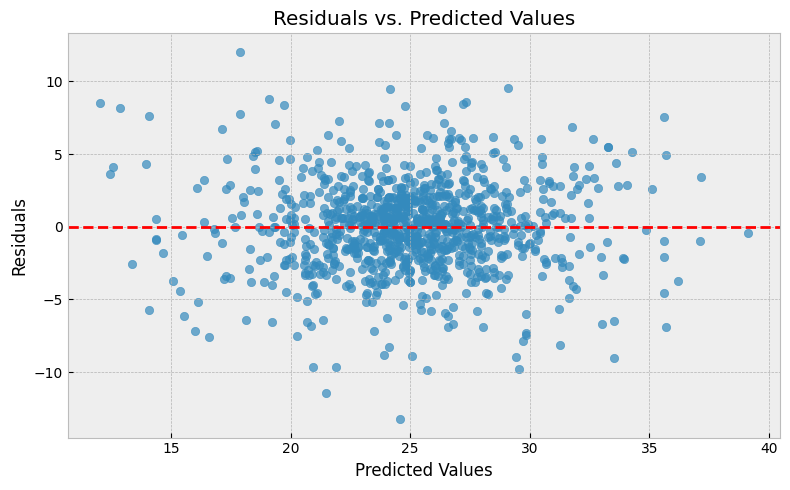

In [24]:
import numpy as np
import pandas as pd
from arch import arch_model

# Set a random seed for reproducibility
np.random.seed(42)

# --- 1. Define and Simulate the GARCH(1,1) process for the errors ---
# These will be the error terms (residuals) for our AR model.
# Parameters are adjusted to make volatility shocks more extreme.
garch_omega = 0.01  # Constant term for variance
garch_alpha = 0.4   # ARCH term (effect of past shocks) - Increased for more spike
garch_beta = 0.55   # GARCH term (effect of past volatility) - Decreased to balance

n_obs = 1000

# Initialize arrays
errors = np.zeros(n_obs)
volatility = np.zeros(n_obs)
shocks = np.random.normal(0, 1, n_obs)

# Set initial volatility
volatility[0] = np.sqrt(garch_omega / (1 - garch_alpha - garch_beta))

# Loop to generate the GARCH errors
for t in range(1, n_obs):
    volatility[t] = np.sqrt(garch_omega + garch_alpha * errors[t-1]**2 + garch_beta * volatility[t-1]**2)
    errors[t] = shocks[t] * volatility[t]


# --- 2. Define and Simulate the AR(1) process using the GARCH errors ---
# This creates the final time series with both AR and GARCH properties.
ar_c = 0.5      # Constant term for the mean
ar_phi = 0.8    # AR(1) coefficient

# Initialize array for the final time series
ar_series = np.zeros(n_obs)
ar_series[0] = ar_c / (1 - ar_phi) # Start at the unconditional mean

# Loop to generate the AR(1) process
for t in range(1, n_obs):
    # The AR(1) equation uses the GARCH errors generated above
    ar_series[t] = ar_c + ar_phi * ar_series[t-1] + errors[t]

# Convert to a pandas Series
ar_garch_series = pd.Series(ar_series, name='ar_garch_series') * 10


# --- 3. Verification: Fit a combined AR(1)-GARCH(1,1) model ---
# This part shows that the model can recover the parameters we set.

# Define the combined model:
# mean='AR' with lags=1 for the AR(1) part.
# vol='Garch' with p=1, q=1 for the GARCH(1,1) part.
model = arch_model(ar_garch_series, mean='AR', lags=1, vol='Garch', p=1, q=1)

# Fit the model
results = model.fit(disp='off')

# Try fitting an AR(1) model to the data
from statsmodels.tsa.ar_model import AutoReg

model_ar1 = AutoReg(ar_garch_series, lags=1)
model_ar1_fit = model_ar1.fit()

# Plot residuals vs. fitted values
y_pred = model_ar1_fit.predict()
residuals = ar_garch_series - y_pred
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.tight_layout()
plt.show()

This looks good, but what happens if I look at residuals over time?

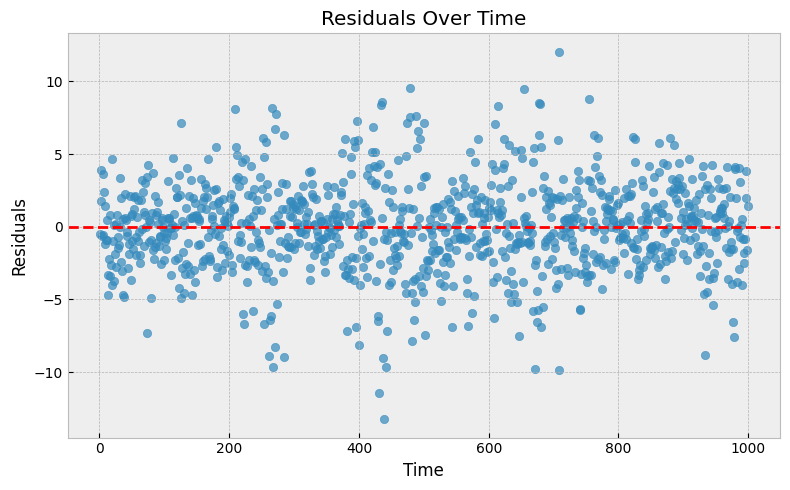

In [25]:
plt.figure(figsize=(8, 5))
plt.scatter(np.arange(len(residuals)), residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals Over Time')
plt.tight_layout()
plt.show()

Okay, so if our residuals were heteroskedastic compared to our *predicted* values, we could use our regular tool kit that we saw in review 2. 

But, how do we deal with heteroskedasticity over time? That is, the variance of our residuals is not a function of the predicted value, but rather a function of time itself.

Additionally, what happens if our residuals are themselves autocorrelated?

#### GARCH Models

GARCH stands for Generalized Autoregressive Conditional Heteroskedasticity. These models are designed to model time series data where the variance of our residuals changes over time.

These are used a lot in econometrics, because there is often periods of high and low volatility. For instance, during COVID or during 2008, you can imagine that the variance *any* prediction we make is much higher, because things are so volatile.

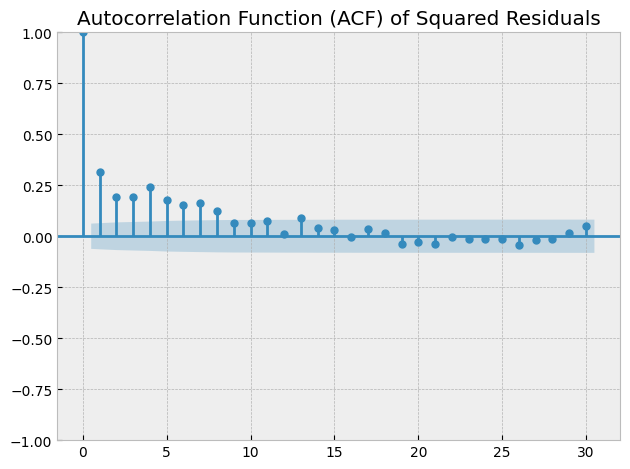

In [26]:
# Plot pacf of residuals
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(residuals.dropna() ** 2, lags=30)
plt.title('Autocorrelation Function (ACF) of Squared Residuals')
plt.tight_layout()
plt.show()

So how can we figure out if ARCH or GARCH is a good fit? Well, we can do the following:
1. Fit my AR model (so $y_t = \beta_0 + \beta_1 y_{t-1} + \epsilon_t$)
2. Get my squared residuals, $\epsilon_t^2$, and then fit *another* AR model to those squared residuals. If the coefficients are significant, then we have evidence of ARCH effects.

In [27]:
# Fit AR model
print("Fitting AR(1) Model")
model_ar1 = AutoReg(ar_garch_series, lags=1)
model_ar1_fit = model_ar1.fit()
display(model_ar1_fit.summary())

print("Fitting AR(1) model to the squared residuals")
model_ar1_sq = AutoReg(residuals.dropna() ** 2, lags=1)
model_ar1_sq_fit = model_ar1_sq.fit()
display(model_ar1_sq_fit.summary())

Fitting AR(1) Model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:        ar_garch_series   No. Observations:                 1000
Model:                     AutoReg(1)   Log Likelihood               -2535.278
Method:               Conditional MLE   S.D. of innovations              3.061
Date:                Sun, 07 Dec 2025   AIC                           5076.555
Time:                        15:15:35   BIC                           5091.276
Sample:                             1   HQIC                          5082.150
                                 1000                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  5.5519      0.506     10.968      0.000       4.560       6.544
ar_garch_series.L1     0.7779      0.020     39.118      0.000       0.739       0.817
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2856           +0.0000j            1.2856            0.0000
-----------------------------------------------------------------------------
"""

Fitting AR(1) model to the squared residuals


/Users/tobiasdelpozo/Documents/School/5th_Year_MSFM/data_analysis_regression/env/lib/python3.14/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  999
Model:                     AutoReg(1)   Log Likelihood               -4180.341
Method:               Conditional MLE   S.D. of innovations             15.955
Date:                Sun, 07 Dec 2025   AIC                           8366.682
Time:                        15:15:35   BIC                           8381.399
Sample:                             1   HQIC                          8372.276
                                  999                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4275      0.578     11.114      0.000       5.294       7.561
y.L1           0.3149      0.030     10.483      0.000       0.256       0.374
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.1753           +0.0000j            3.1753            0.0000
-----------------------------------------------------------------------------
"""

This is an example of an AR(1)-ARCH(1) model, since we're only using one lag in both the mean and variance equations. The python package `arch` has a lot of different options. 

The nice thing about this model is that we still we can now make predictions with varying confidence.

In [28]:
# Fit an ARCH model
arch_model_ = arch_model(ar_garch_series, mean='AR', lags=1, vol='ARCH', p=1)
arch_results = arch_model_.fit(disp='off')
arch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - ARCH Model Results                            
==============================================================================
Dep. Variable:        ar_garch_series   R-squared:                       0.605
Mean Model:                        AR   Adj. R-squared:                  0.604
Vol Model:                       ARCH   Log-Likelihood:               -2469.67
Distribution:                  Normal   AIC:                           4947.34
Method:            Maximum Likelihood   BIC:                           4966.97
                                        No. Observations:                  999
Date:                Sun, Dec 07 2025   Df Residuals:                      997
Time:                        15:15:35   Df Model:                            2
                                 Mean Model                                
===========================================================================
                    coef    std err          t      P>|t|  95.0% Conf. Int.
---------------------------------------------------------------------------
Const             5.0899      0.575      8.845  9.183e-19 [  3.962,  6.218]
ar_g...ies[1]     0.7978  2.265e-02     35.223 8.910e-272 [  0.753,  0.842]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          5.4671      0.467     11.700  1.269e-31 [  4.551,  6.383]
alpha[1]       0.4359  6.005e-02      7.259  3.893e-13 [  0.318,  0.554]
========================================================================

Covariance estimator: robust
"""

In [29]:
model_700 = arch_model(ar_garch_series.iloc[:700], mean='AR', lags=1, vol='ARCH', p=1)
results_700 = model_700.fit(disp='off')

# Forecast one step ahead (for point 701)
forecast_700 = results_700.forecast(horizon=1)

forecast_1000 = results.forecast(horizon=1)

# Display the forecasts
print("Forecast from 700th data point:")
print(forecast_700.mean.iloc[-1])
print(forecast_700.variance.iloc[-1])
print("\nForecast from 1000th data point:")
print(forecast_1000.mean.iloc[-1])
print(forecast_1000.variance.iloc[-1])

Forecast from 700th data point:
h.1    25.420061
Name: 699, dtype: float64
h.1    6.006416
Name: 699, dtype: float64

Forecast from 1000th data point:
h.1    26.094862
Name: 999, dtype: float64
h.1    5.256756
Name: 999, dtype: float64


### Next Class
1. PCA and Dimensionality Reduction
2. Boosting and Bagging
3. Tree-based methods and Random Forests